# Computer Networks Computer Assignment 2
## Arman Rostami, Parsa Ghorbani

### Initialization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SIMULATION_COUNT = 1
TCL_FILENAME = "congestion.tcl"
CWND_FILENAME_1 = "cwnd1.csv"
CWND_FILENAME_2 = "cwnd2.csv"
GOODPUT_FILENAME_1 = "goodput1.csv"
GOODPUT_FILENAME_2 = "goodput2.csv"
RTT_FILENAME_1 = "rtt1.csv"
RTT_FILENAME_1 = "rtt2.csv"

In [3]:
plt.rcParams["figure.figsize"] = (14, 5) 

### Simulator

In [4]:
class Simulator:
    def __init__(self, congestion_algorithm):
        self.congestion_algorithm = congestion_algorithm

In [5]:
def train(self):
    for i in range(0, SIMULATION_COUNT):
        os.system("ns " + TCL_FILENAME + " " + self.congestion_algorithm)
        self.update_cwnd(i)
        
Simulator.train = train

In [67]:
def plot_data(self, data_1, data_2):
    plt.plot(data_1, "b", label="Top flow")
    plt.plot(data_2, "r", label="Bottom flow")
    plt.xlabel("time")
    plt.ylabel(data_1.name)
    plt.legend()

Simulator.plot_data = plot_data

In [7]:
def update_cwnd(self, simulation_index):
    cwnd_new_data_1 = pd.read_csv(CWND_FILENAME_1)
    cwnd_new_data_2 = pd.read_csv(CWND_FILENAME_2)
    
    if simulation_index == 0:
        self.cwnd_data_1 = cwnd_new_data_1
        self.cwnd_data_2 = cwnd_new_data_2
    else:
        self.cwnd_data_1["cwnd"] += cwnd_new_data_1["cwnd"]
        self.cwnd_data_2["cwnd"] += cwnd_new_data_2["cwnd"]
        
    if simulation_index == SIMULATION_COUNT - 1:
        self.cwnd_data_1["cwnd"] /= SIMULATION_COUNT
        self.cwnd_data_2["cwnd"] /= SIMULATION_COUNT
    
Simulator.update_cwnd = update_cwnd

In [13]:
def plot_cwnd(self):
    self.plot_data(self.cwnd_data_1["cwnd"], self.cwnd_data_2["cwnd"])
    
Simulator.plot_cwnd = plot_cwnd

### Train Simulators

In [14]:
new_reno_simulator = Simulator("Newreno")
new_reno_simulator.train()

In [15]:
tahoe_simulator = Simulator("Tahoe")
tahoe_simulator.train()

In [16]:
vegas_simulator = Simulator("Vegas")
vegas_simulator.train()

### CWND

#### Newreno

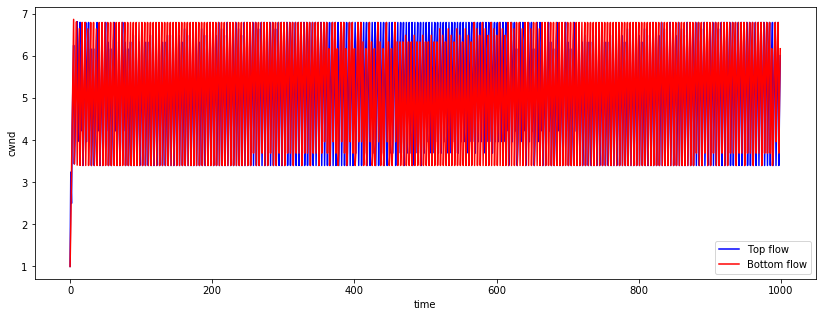

In [68]:
new_reno_simulator.plot_cwnd()

#### Tahoe

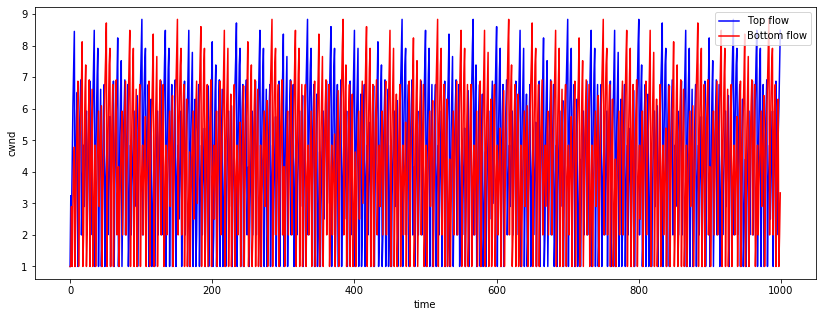

In [69]:
tahoe_simulator.plot_cwnd()

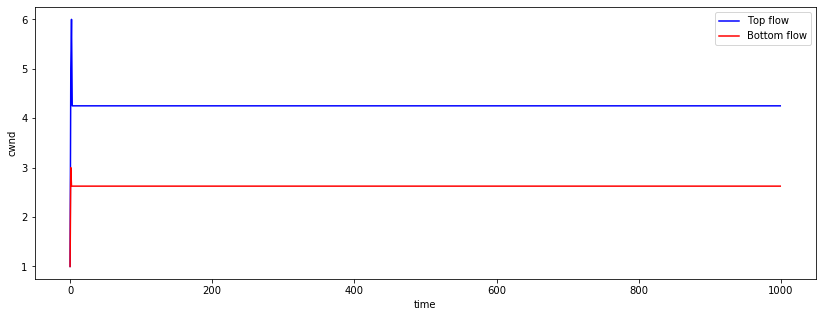

In [70]:
vegas_simulator.plot_cwnd()